<a href="https://colab.research.google.com/github/IonutMotoi/Thesis/blob/detectron2/Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install detectron2

In [ ]:
!pip install pyyaml==5.1
# workaround: install old version of pytorch since detectron2 hasn't released packages for pytorch 1.9 (issue: https://github.com/facebookresearch/detectron2/issues/3158)
!pip install torch==1.8.0+cu101 torchvision==0.9.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

# install detectron2 that matches pytorch 1.8
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html


In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.8")   # please manually install torch 1.8 if Colab changes its default version

1.8.0+cu101 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.modeling import build_model

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset (with masks)

In [ ]:
import pycocotools
from detectron2.structures import BoxMode

data_path = "/content/drive/MyDrive/Thesis/Mask RCNN/wgisd"

def get_wgisd_dicts(root, source):

  # Load the dataset subset defined by source
  assert source in ('train', 'valid', 'test'), \
        'source should be "train", "valid" or "test"'

  if source == 'train':
    source_path = os.path.join(root, 'train_split_masked.txt')
  if source == 'valid':
    source_path = os.path.join(root, 'valid_split_masked.txt')
  else:
    source_path = os.path.join(root, 'test_masked.txt')

  with open(source_path, 'r') as fp:
    # Read all lines in file
    lines = fp.readlines()
    # Recover the items ids, removing the \n at the end
    ids = [l.rstrip() for l in lines]

  imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
  masks = [os.path.join(root, 'data', f'{id}.npz') for id in ids]
  boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

  dataset_dicts = []
  for id in ids:
    record = {}
    
    filename = os.path.join(root, 'data', f'{id}.jpg')
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = id
    record["height"] = height
    record["width"] = width
  
    box_path = os.path.join(root, 'data', f'{id}.txt')
    mask_path = os.path.join(root, 'data', f'{id}.npz')

    wgisd_masks = np.load(mask_path)['arr_0'].astype(np.uint8)
    num_objs = wgisd_masks.shape[2]

    boxes_text = np.loadtxt(box_path, delimiter=" ", dtype=np.float32)
    wgisd_boxes = boxes_text[:, 1:]
    assert (wgisd_boxes.shape[0] == num_objs)    

    objs = []
    for i in range(num_objs):
      box = wgisd_boxes[i]
      mask = wgisd_masks[:,:,i]

      # Boxes (x0, y0, w, h) in range [0, 1]
      # They are relative to the size of the image
      # Convert to (x0, y0, x1, y1) in absolute floating points coordinates
      x1 = box[0] - box[2] / 2
      x2 = box[0] + box[2] / 2
      y1 = box[1] - box[3] / 2
      y2 = box[1] + box[3] / 2
      box = [x1 * width, y1 * height, x2 * width, y2 * height]
      
      # Convert a uint8 mask of 0s and 1s into dict 
      # with keys “size” and “counts”
      mask = pycocotools.mask.encode(np.asarray(mask, order="F"))
      
      obj = {
          "bbox": box,
          "bbox_mode": BoxMode.XYXY_ABS,
          "segmentation": mask,
          "category_id": 0,
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts


for d in ["train", "valid", "test"]:
  dataset_name = "wgisd_" + d
  if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)

  DatasetCatalog.register(dataset_name, lambda d=d: get_wgisd_dicts(data_path, d))
  MetadataCatalog.get(dataset_name).set(thing_classes=["grapes"])

wgisd_metadata = MetadataCatalog.get("wgisd_train")
wgisd_metadata.size = 88
MetadataCatalog.get("wgisd_valid").set(evaluator_type = "coco")
MetadataCatalog.get("wgisd_test").set(evaluator_type = "coco")

Metadata(evaluator_type='coco', name='wgisd_test', thing_classes=['grapes'])

### Show examples

In [ ]:
# # Show three GT examples from the train dataset

# dataset_dicts = get_wgisd_dicts(data_path, "train")
# for d in random.sample(dataset_dicts, 3):
# # for d in dataset_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=wgisd_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

# Dataset (Bounding Boxes only)

In [ ]:
import pycocotools
from detectron2.structures import BoxMode

data_path = "/content/drive/MyDrive/Thesis/Mask RCNN/wgisd"

def get_wgisd_BB_dicts(root, source):

    # Load the dataset subset defined by source
  assert source in ('train', 'test'), \
        'source should be "train" or "test"'

  if source == 'train':
    source_path = os.path.join(root, 'pretrain_no_masked_valid_ids.txt')
    # source_path = os.path.join(root, 'pretrain_no_masked_train_valid_ids.txt')
    
  else:
    source_path = os.path.join(root, 'test.txt')

  with open(source_path, 'r') as fp:
      # Read all lines in file
      lines = fp.readlines()
      # Recover the items ids, removing the \n at the end
      ids = [l.rstrip() for l in lines]

  imgs = [os.path.join(root, 'data', f'{id}.jpg') for id in ids]
  boxes = [os.path.join(root, 'data', f'{id}.txt') for id in ids]

  dataset_dicts = []
  for id in ids:
    record = {}
    
    filename = os.path.join(root, 'data', f'{id}.jpg')
    height, width = cv2.imread(filename).shape[:2]

    record["file_name"] = filename
    record["image_id"] = id
    record["height"] = height
    record["width"] = width
  
    box_path = os.path.join(root, 'data', f'{id}.txt')    
    boxes_text = np.loadtxt(box_path, delimiter=" ", dtype=np.float32)
    wgisd_boxes = boxes_text[:, 1:]
    num_objs = wgisd_boxes.shape[0]  

    objs = []
    for i in range(num_objs):
      box = wgisd_boxes[i]
      # Boxes (x0, y0, w, h) in range [0, 1]
      # They are relative to the size of the image
      # Convert to (x0, y0, x1, y1) in absolute floating points coordinates
      x1 = box[0] - box[2] / 2
      x2 = box[0] + box[2] / 2
      y1 = box[1] - box[3] / 2
      y2 = box[1] + box[3] / 2
      box = [x1 * width, y1 * height, x2 * width, y2 * height]

      # Bounding Box to Mask
      # mask = np.zeros((height,width), dtype=np.uint8)
      # mask[int(box[1]):int(box[3]), int(box[0]):int(box[2])] = 1
      # Convert a uint8 mask of 0s and 1s into dict 
      # with keys “size” and “counts”
      # mask = pycocotools.mask.encode(np.asarray(mask, order="F"))

      obj = {
          "bbox": box,
          "bbox_mode": BoxMode.XYXY_ABS,
          # "segmentation": mask,
          "category_id": 0,
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts


for d in ["train", "test"]:
  dataset_name = "wgisd_BB_" + d
  if dataset_name in DatasetCatalog.list():
    DatasetCatalog.remove(dataset_name)
    
  DatasetCatalog.register(dataset_name, lambda d=d: get_wgisd_BB_dicts(data_path, d))
  MetadataCatalog.get(dataset_name).set(thing_classes=["grapes"])

wgisd_BB_metadata = MetadataCatalog.get("wgisd_BB_train")
wgisd_BB_metadata.size = 220  # pretrain_no_masked_valid_ids
# wgisd_BB_metadata.size = 132  # pretrain_no_masked_train_valid_ids

### Show examples (Bounding Boxes only)

In [ ]:
# # Show three GT examples from the train dataset

# dataset_dicts = get_wgisd_BB_dicts(data_path, "train")
# for d in random.sample(dataset_dicts, 3):
# # for d in dataset_dicts:
#     img = cv2.imread(d["file_name"])
#     visualizer = Visualizer(img[:, :, ::-1], metadata=wgisd_BB_metadata, scale=0.5)
#     out = visualizer.draw_dataset_dict(d)
#     cv2_imshow(out.get_image()[:, :, ::-1])

# Mask R-CNN

In [ ]:
# Configuration
epochs = 90
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wgisd_train",)
cfg.DATASETS.TEST = ("wgisd_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.INPUT.MASK_FORMAT = "bitmask"
# Let training initialize from model zoo
# COCO Instance Segmentation Baselines with Mask R-CNN
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# New baselines using Large-Scale Jitter and Longer Training Schedule
# cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/detectron2/new_baselines/mask_rcnn_R_50_FPN_400ep_LSJ/42019571/model_final_14d201.pkl"
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.005
iter_per_epoch = int(np.ceil(wgisd_metadata.size / cfg.SOLVER.IMS_PER_BATCH))
cfg.SOLVER.MAX_ITER = iter_per_epoch * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = iter_per_epoch  # checkpoint after each epoch
cfg.SOLVER.STEPS = [60*iter_per_epoch, 80*iter_per_epoch]
cfg.SOLVER.WARMUP_ITERS = 5*iter_per_epoch
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only one class (grapes)
cfg.MODEL.MASK_ON = True
# Evaluate every x epochs
cfg.TEST.EVAL_PERIOD = 5*iter_per_epoch

# Folder for the experiment/run
cfg.OUTPUT_DIR = "/content/drive/MyDrive/Thesis/Mask RCNN/output_bb_pretrain_50ep_segm_50ep"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# Build the model
model = build_model(cfg)

# Engine

In [ ]:
import logging
import os
from collections import OrderedDict
import torch
from torch.nn.parallel import DistributedDataParallel

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer, PeriodicCheckpointer
from detectron2.config import get_cfg
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.engine import default_argument_parser, default_setup, default_writers, launch
from detectron2.evaluation import (
    COCOEvaluator,
    DatasetEvaluators,
    inference_on_dataset,
    print_csv_format,
)
from detectron2.modeling import build_model
from detectron2.solver import build_lr_scheduler, build_optimizer
from detectron2.utils.events import EventStorage

logger = logging.getLogger("detectron2")


def get_evaluator(cfg, dataset_name, output_folder=None):
    """
    Create evaluator(s) for a given dataset.
    This uses the special metadata "evaluator_type" associated with each builtin dataset.
    For your own dataset, you can simply create an evaluator manually in your
    script and do not have to worry about the hacky if-else logic here.
    """
    if output_folder is None:
        output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
    evaluator_list = []
    evaluator_type = MetadataCatalog.get(dataset_name).evaluator_type
    if evaluator_type == "coco":
        evaluator_list.append(COCOEvaluator(dataset_name, output_dir=output_folder))
    if len(evaluator_list) == 0:
        raise NotImplementedError(
            "no Evaluator for the dataset {} with the type {}".format(dataset_name, evaluator_type)
        )
    if len(evaluator_list) == 1:
        return evaluator_list[0]
    return DatasetEvaluators(evaluator_list)


def do_test(cfg, model):
    results = OrderedDict()
    for dataset_name in cfg.DATASETS.TEST:
        data_loader = build_detection_test_loader(cfg, dataset_name)
        evaluator = get_evaluator(
            cfg, dataset_name, os.path.join(cfg.OUTPUT_DIR, "inference", dataset_name)
        )
        results_i = inference_on_dataset(model, data_loader, evaluator)
        results[dataset_name] = results_i
        if comm.is_main_process():
            logger.info("Evaluation results for {} in csv format:".format(dataset_name))
            print_csv_format(results_i)
    if len(results) == 1:
        results = list(results.values())[0]
    return results


def do_train(cfg, model, resume=False):
    model.train()

    optimizer = build_optimizer(cfg, model)
    scheduler = build_lr_scheduler(cfg, optimizer)

    checkpointer = DetectionCheckpointer(
        model, cfg.OUTPUT_DIR, optimizer=optimizer, scheduler=scheduler
    )
    start_iter = (
        checkpointer.resume_or_load(cfg.MODEL.WEIGHTS, resume=resume).get("iteration", -1) + 1
    )
    max_iter = cfg.SOLVER.MAX_ITER

    periodic_checkpointer = PeriodicCheckpointer(
        checkpointer, cfg.SOLVER.CHECKPOINT_PERIOD, max_iter=max_iter
    )

    writers = default_writers(cfg.OUTPUT_DIR, max_iter) if comm.is_main_process() else []

    # compared to "train_net.py", we do not support accurate timing and
    # precise BN here, because they are not trivial to implement in a small training loop
    data_loader = build_detection_train_loader(cfg)
    logger.info("Starting training from iteration {}".format(start_iter))
    with EventStorage(start_iter) as storage:
        for data, iteration in zip(data_loader, range(start_iter, max_iter)):
            storage.iter = iteration

            if (iteration + 1) % 5 == 0:
              print("Iteration: ", iteration + 1, "/", max_iter)

            loss_dict = model(data)
            losses = sum(loss_dict.values())
            assert torch.isfinite(losses).all(), loss_dict

            loss_dict_reduced = {k: v.item() for k, v in comm.reduce_dict(loss_dict).items()}
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            if comm.is_main_process():
                storage.put_scalars(total_loss=losses_reduced, **loss_dict_reduced)

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            storage.put_scalar("lr", optimizer.param_groups[0]["lr"], smoothing_hint=False)
            scheduler.step()

            if (
                (cfg.TEST.EVAL_PERIOD > 0
                and (iteration + 1) % cfg.TEST.EVAL_PERIOD == 0
                and iteration != 0)
                or 
                (cfg.TEST.EVAL_PERIOD > 0
                 and (iteration + 1) == max_iter)
            ):
                do_test(cfg, model)
                # Compared to "train_net.py", the test results are not dumped to EventStorage
                comm.synchronize()

            if iteration - start_iter > 5 and (
                (iteration + 1) % 20 == 0 or (iteration + 1) == max_iter
            ):
                for writer in writers:
                    writer.write()
            periodic_checkpointer.step(iteration)

def train_loop(cfg, model) 

def setup(args):
    """
    Create configs and perform basic setups.
    """
    cfg = get_cfg()
    cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    default_setup(
        cfg, args
    )  # if you don't like any of the default setup, write your own setup code
    return cfg


# def main(args):
#     cfg = setup(args)

#     model = build_model(cfg)
#     logger.info("Model:\n{}".format(model))
#     if args.eval_only:
#         DetectionCheckpointer(model, save_dir=cfg.OUTPUT_DIR).resume_or_load(
#             cfg.MODEL.WEIGHTS, resume=args.resume
#         )
#         return do_test(cfg, model)

#     distributed = comm.get_world_size() > 1
#     if distributed:
#         model = DistributedDataParallel(
#             model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
#         )

#     do_train(cfg, model, resume=args.resume)
#     return do_test(cfg, model)


# if __name__ == "__main__":
#     args = default_argument_parser().parse_args()
#     print("Command Line Args:", args)
#     launch(
#         main,
#         args.num_gpus,
#         num_machines=args.num_machines,
#         machine_rank=args.machine_rank,
#         dist_url=args.dist_url,
#         args=(args,),
#     )


# Train

In [ ]:
do_train(cfg, model)

# Train 2

### Pretrain on bounding boxes only dataset (larger dataset)

In [ ]:
epochs = 18
cfg.DATASETS.TRAIN = ("wgisd_BB_train",)
iter_per_epoch = int(wgisd_BB_metadata.size / cfg.SOLVER.IMS_PER_BATCH)
cfg.SOLVER.MAX_ITER = iter_per_epoch * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = iter_per_epoch  # checkpoint after each epoch
cfg.SOLVER.STEPS = []
cfg.TEST.EVAL_PERIOD = 5*iter_per_epoch
pretrain_iter = cfg.SOLVER.MAX_ITER
cfg.MODEL.MASK_ON = False

model = build_model(cfg)

do_train(cfg, model)

### Finetune on instance segmentation dataset (smaller dataset)

In [ ]:
epochs = 90
cfg.DATASETS.TRAIN = ("wgisd_train",)
iter_per_epoch = int(wgisd_metadata.size / cfg.SOLVER.IMS_PER_BATCH)
cfg.SOLVER.MAX_ITER = pretrain_iter + iter_per_epoch * epochs
cfg.SOLVER.CHECKPOINT_PERIOD = iter_per_epoch  # checkpoint after each epoch
cfg.SOLVER.STEPS = [pretrain_iter+60*iter_per_epoch, pretrain_iter+80*iter_per_epoch]
cfg.TEST.EVAL_PERIOD = 5*iter_per_epoch
cfg.MODEL.MASK_ON = True

# Use the weights of the model pretrained on the bounding box only dataset
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

model = build_model(cfg)

do_train(cfg, model)

# Validation

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

In [ ]:
# Show some examples of predictions on the validation dataset

from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_wgisd_dicts(data_path, "test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=wgisd_metadata, 
                   scale=0.5, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Evaluate on the validation dataset

from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("wgisd_valid", ("bbox", "segm"), False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "wgisd_valid")
print(inference_on_dataset(model, val_loader, evaluator))

# Test on a single image

In [ ]:
# Inference should use the config with parameters that are used in training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

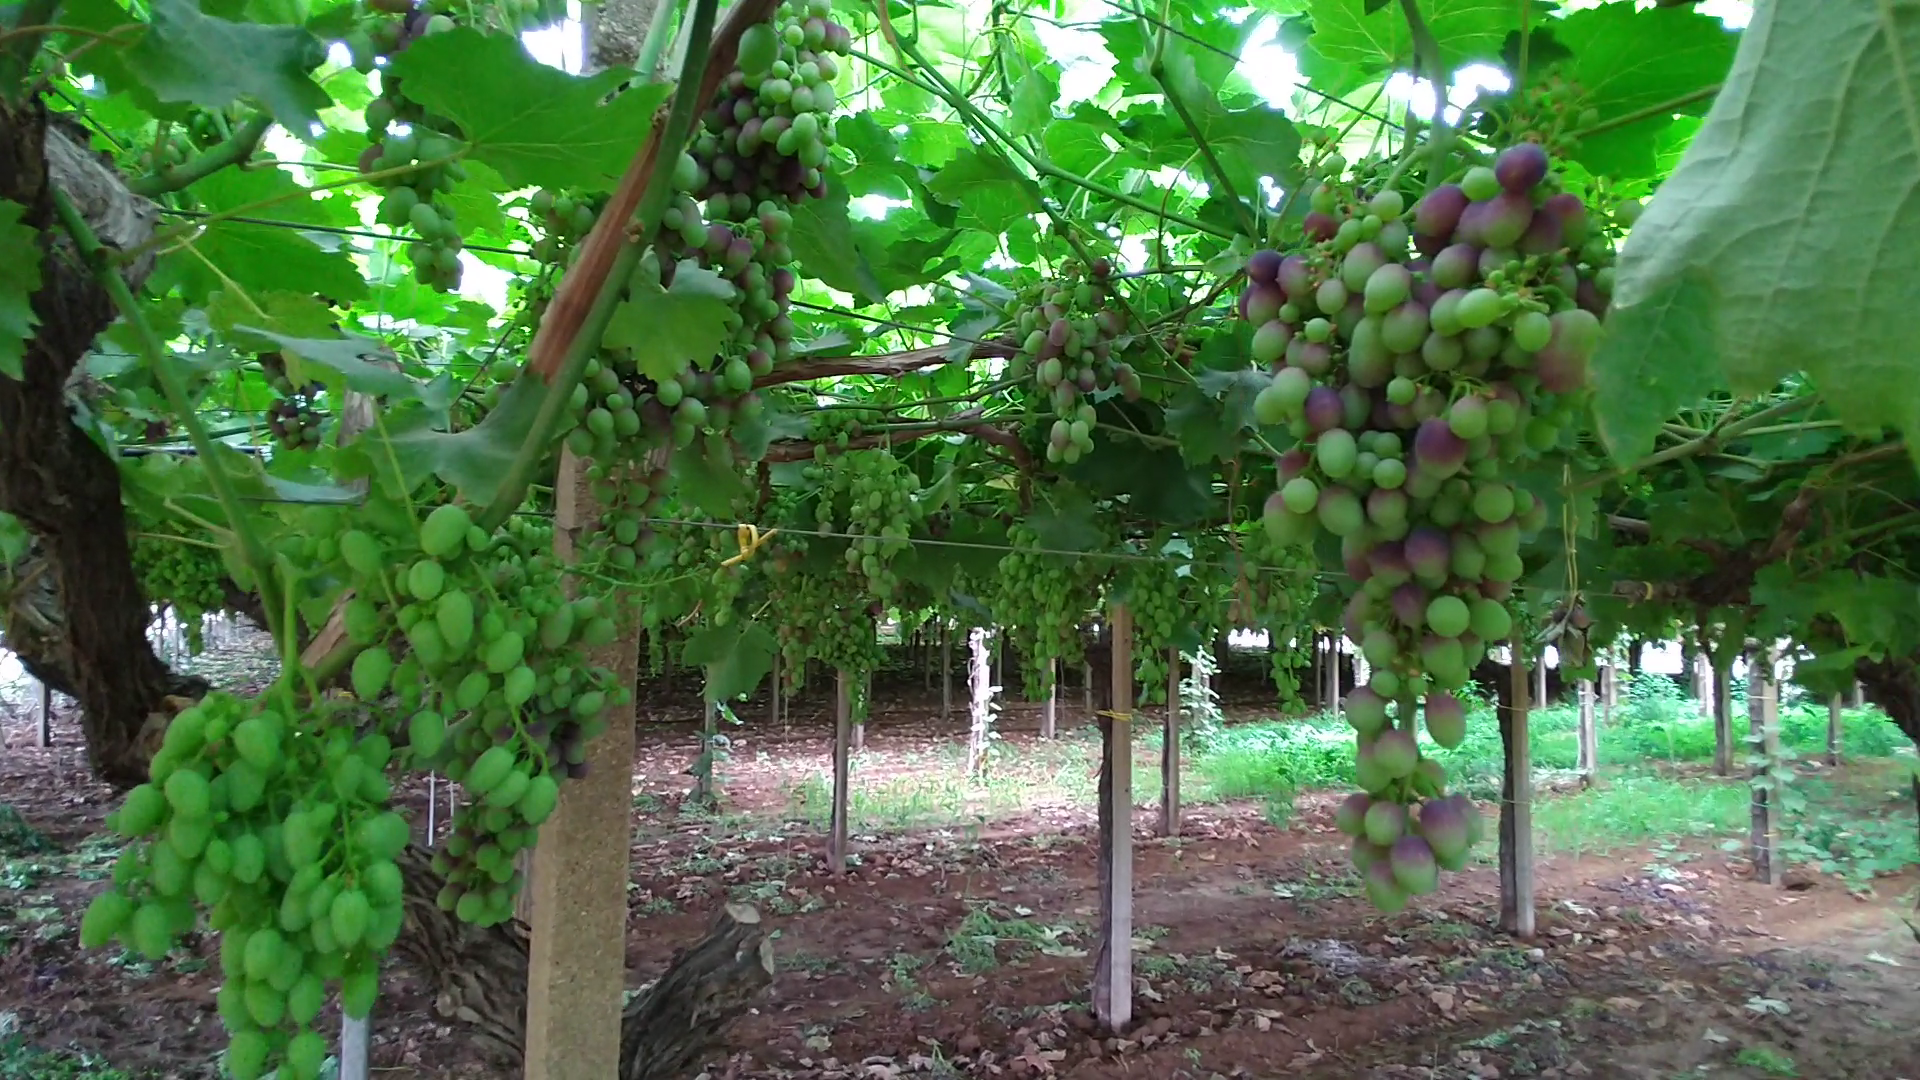

In [ ]:
im = cv2.imread("/content/drive/MyDrive/Thesis/Mask RCNN/test_image.png")
cv2_imshow(im)

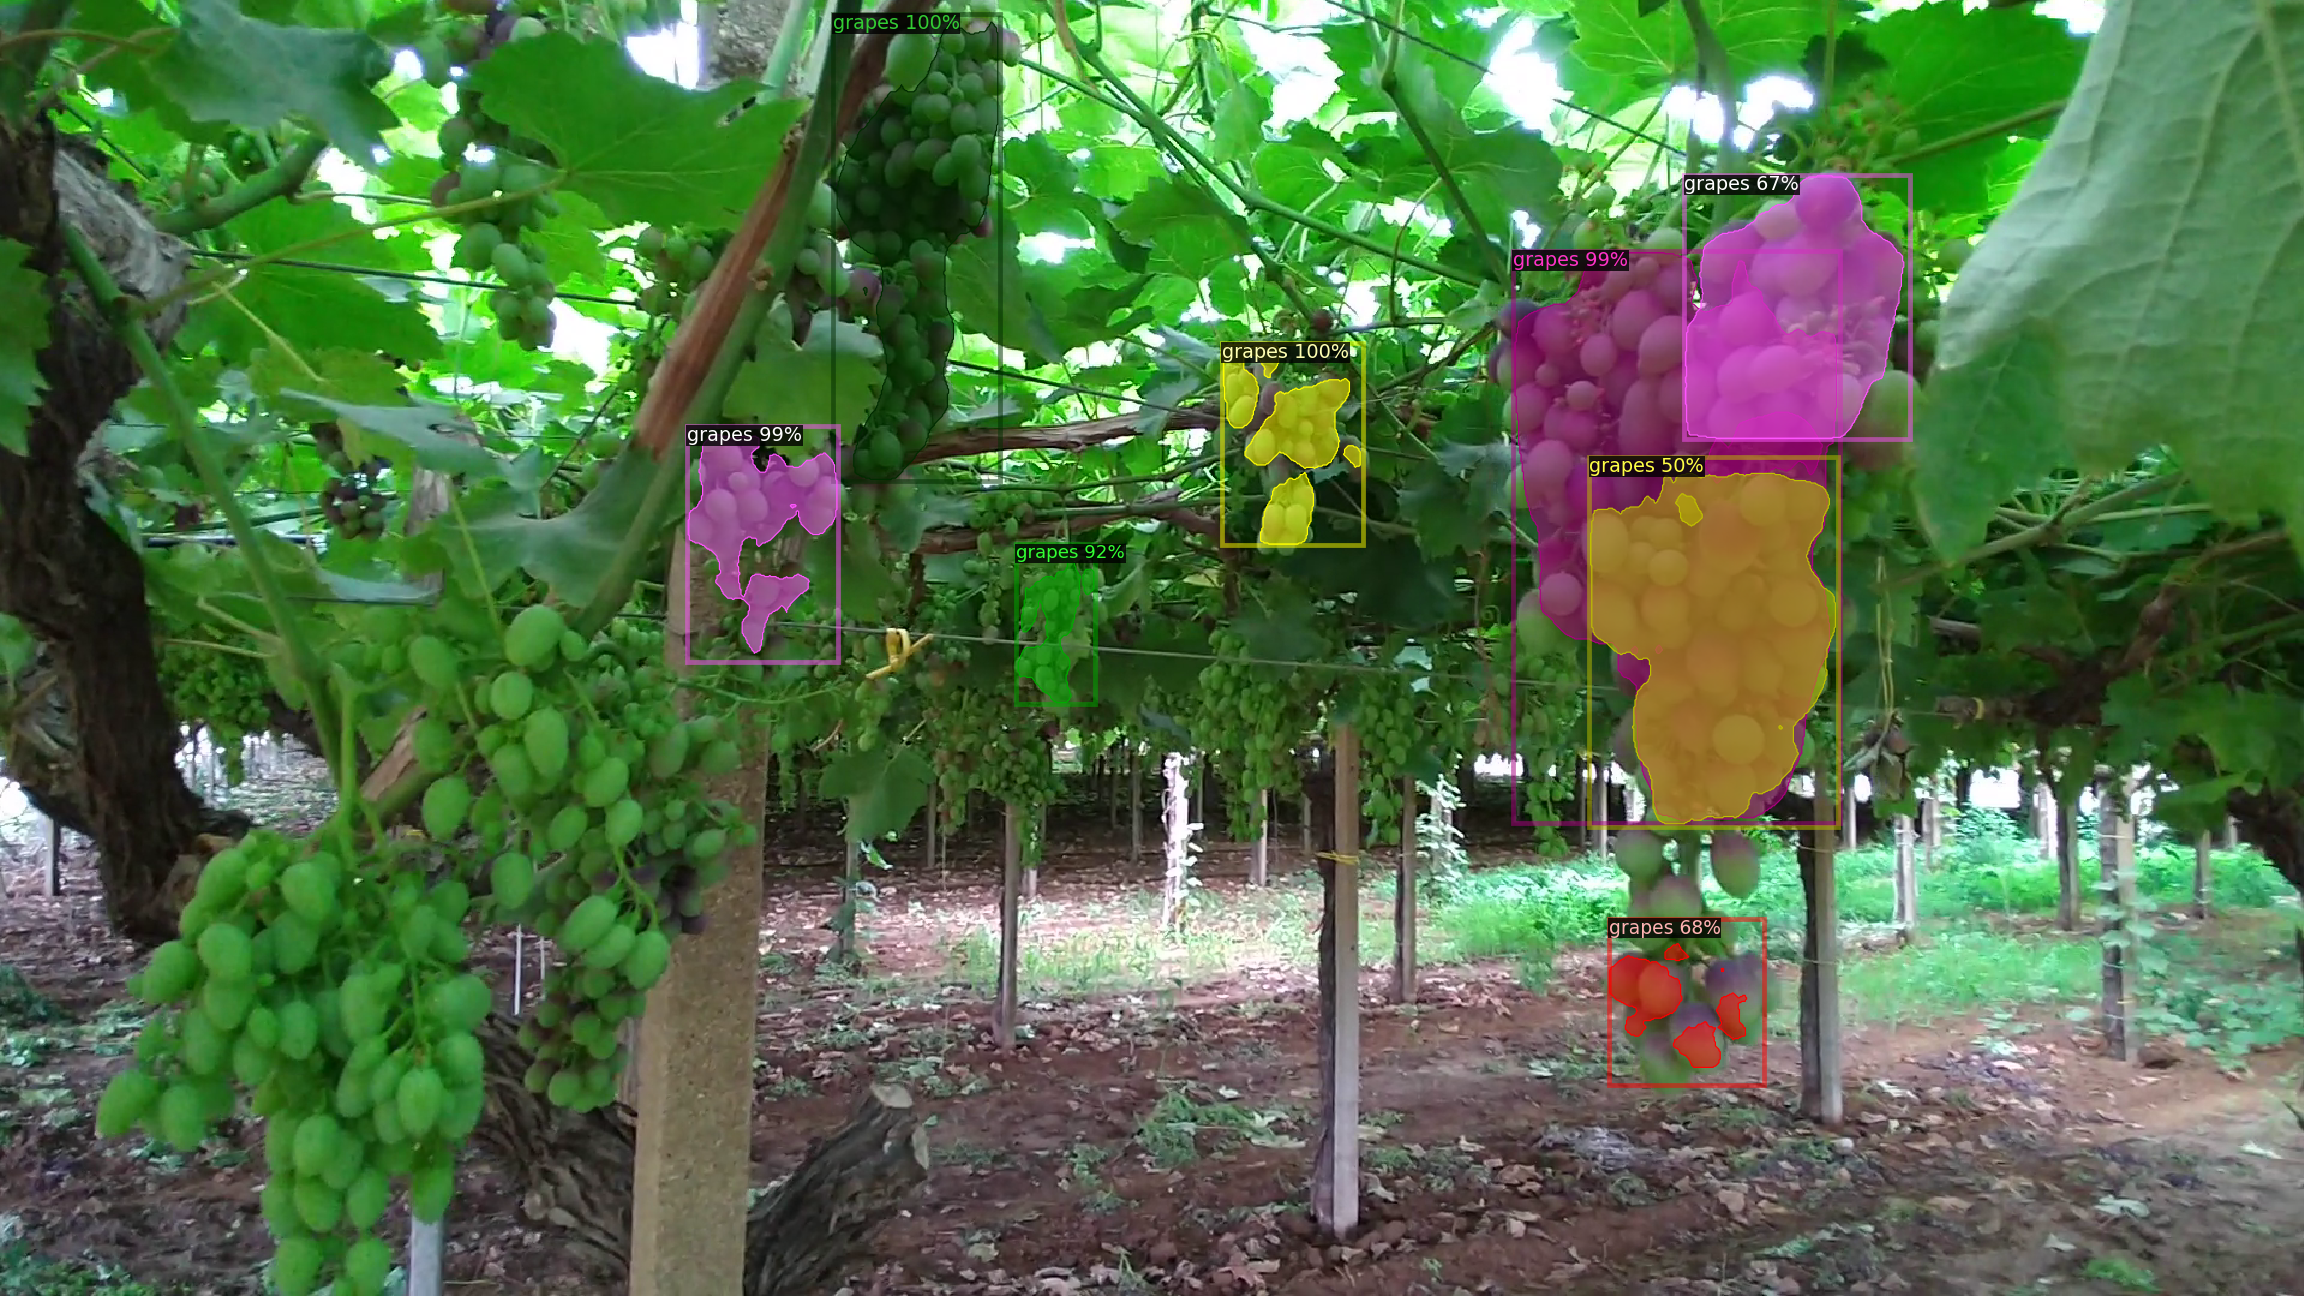

In [ ]:
outputs = predictor(im)
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])